# Deep Learning

This notebook tackles the classic [MNIST](https://en.wikipedia.org/wiki/MNIST_database) classification task, as a proxy for building simple neural networks with PyTorch.

## Imports and Configuration

In [1]:
from typing import Sequence

import torch
import torchvision
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

torch.manual_seed(1)

## Get Dataset

In [2]:
train_data = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

print(f'{len(train_data):,} instances of training data')
print(f'{len(test_data):,} instances of training data')

60,000 instances of training data
10,000 instances of training data


Inspect a single instance of training data.

label = 5


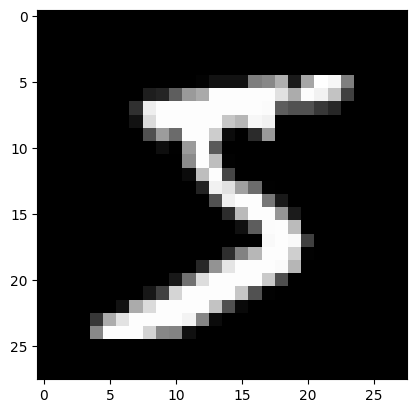

In [3]:
data_instance, data_label = train_data[0]
print(f'label = {data_label}')
_ = plt.imshow(data_instance[0], cmap='gray')

## Training a Classification Model

Start by defining the network that we want to train.

In [4]:
class ClassifyMNIST(nn.Module):
    """MNIST classification network."""
    
    def __init__(self, n_hidden_neurons):
        super().__init__()
        self.input_dim = 28 * 28
        self.n_classes = 10
        self.n_hidden_neurons = n_hidden_neurons
        self.model = nn.Sequential(
            nn.Linear(self.input_dim, n_hidden_neurons),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons, self.n_classes)
        )
        
    
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Compute a prediction."""
        return self.model(X)

And then the training routine to use with it.

In [5]:
def train(
    model: nn.Module,
    criterion: nn.Module,
    data_loader: DataLoader,
    n_epochs: int,
    learning_rate: float
) -> Sequence[float]:
    """Train the model over multiple epochs recording the loss for each."""

    def process_batch(X: torch.Tensor, y: torch.Tensor) -> float:
        y_hat = model.forward(X.view(-1, model.input_dim))
        loss = criterion(y_hat, y)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        return loss.detach().numpy().tolist()

    def process_epoch(n: int) -> float:
        return [process_batch(X, y) for X, y in data_loader][-1]

    optimiser = torch.optim.SGD(model.parameters(), lr=0.05)
    training_run = [process_epoch(epoch) for epoch in tqdm(range(n_epochs))]
    return training_run

Train the model!

In [6]:
training_data_loader = DataLoader(dataset=train_data, batch_size=500)
model = ClassifyMNIST(28*28)
loss_func = nn.CrossEntropyLoss()
train(model, loss_func, training_data_loader, n_epochs=10, learning_rate=0.05)

100%|██████████| 10/10 [00:19<00:00,  1.95s/it]


[0.6655572652816772,
 0.39592447876930237,
 0.3300316035747528,
 0.3028208613395691,
 0.2876836657524109,
 0.27742865681648254,
 0.26953956484794617,
 0.26290494203567505,
 0.25701382756233215,
 0.25152701139450073]

Asses the model on the test dataset.

In [7]:
test_data_loader = DataLoader(dataset=test_data, batch_size=10000)
correct = 0
for X, y in test_data_loader:
    _, y_hat = torch.max(model.forward(X.view(-1, 28*28)), 1)
    correct += (y_hat == y).sum()
accuracy = correct / len(test_data)
accuracy

tensor(0.9236)

Let's test it on the test instance displayed above.

In [8]:
output_from_final_layer = model(data_instance.view(-1, 28*28))
value, index = torch.max(output_from_final_layer, 1)
index

tensor([5])